In [10]:
from torch_geometric.datasets import ModelNet
from torch_geometric.transforms import SamplePoints

transform = SamplePoints(1024)
train_dataset = ModelNet(root='modelnet10', name='10', train=True, transform=transform)
test_dataset = ModelNet(root='modelnet10', name='10', train=False, transform=transform)

In [34]:
for i, c in enumerate(classes):
    print(i, c)

0 bathtub
1 bed
2 chair
3 desk
4 dresser
5 monitor
6 night_stand
7 sofa
8 table
9 toilet


monitor found at index 1910


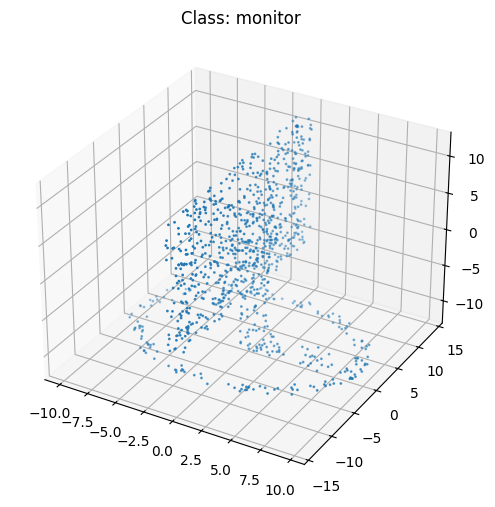

In [44]:
import os
import matplotlib.pyplot as plt

classes = sorted([
    folder for folder in os.listdir('modelnet10/raw')
    if not folder.startswith('.') and os.path.isdir(f'modelnet10/raw/{folder}')
])


def visualize_point_cloud(data):
    pos = data.pos.numpy()
    label = classes[data.y.item()]
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=1)
    ax.set_title(f'Class: {label}')
    plt.show()

monitor_index = classes.index("monitor")

for i, data in enumerate(train_dataset):
    if data.y.item() == monitor_index:
        print(f"monitor found at index {i}")
        visualize_point_cloud(data)
        break

In [ ]:
output_dir = 'output_shapes'
os.makedirs(output_dir, exist_ok=True)

In [20]:
from mpl_toolkits.mplot3d import Axes3D

num_samples = 10
for i in range(num_samples):
    data = train_dataset[i]
    pos = data.pos.numpy()
    label = classes[data.y.item()]

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=5)
    ax.set_title(f'Class: {label}')

    filename = f"{output_dir}/{i+1}_{label}.png"
    plt.savefig(filename)
    plt.close(fig)

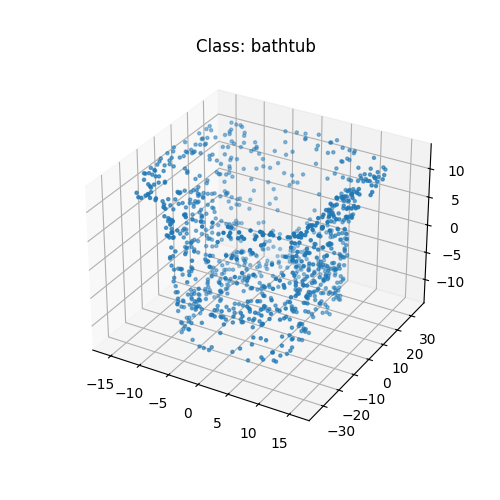

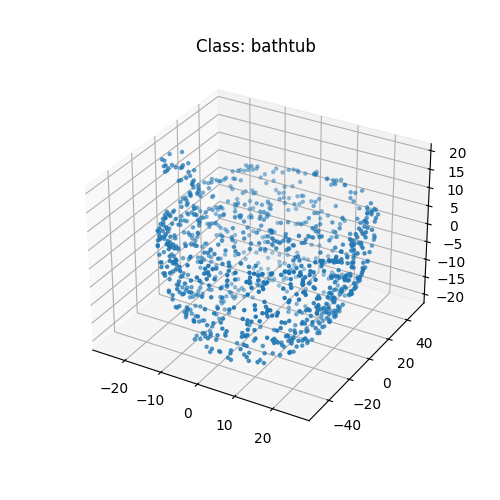

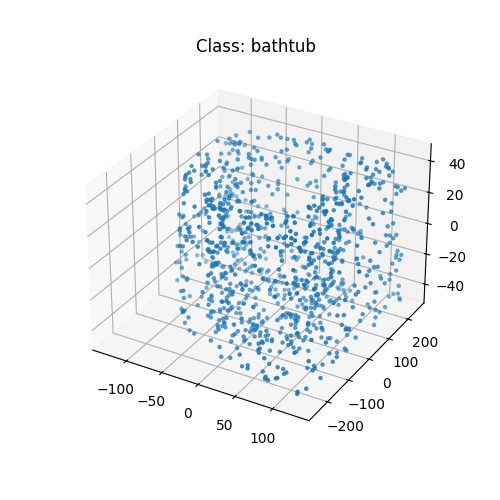

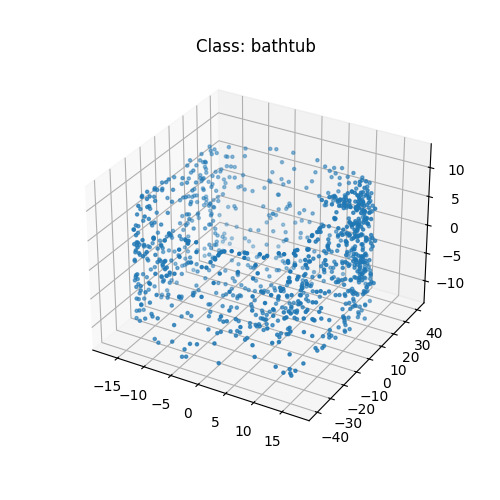

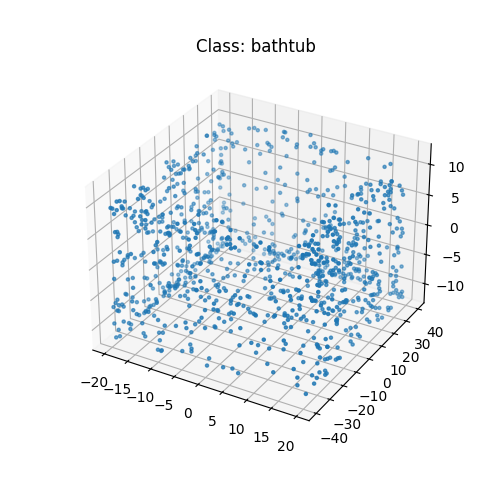

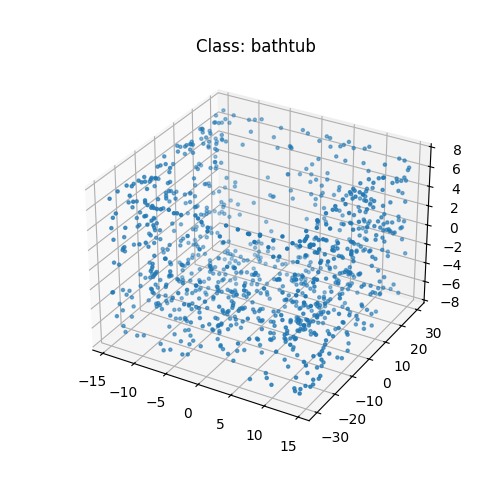

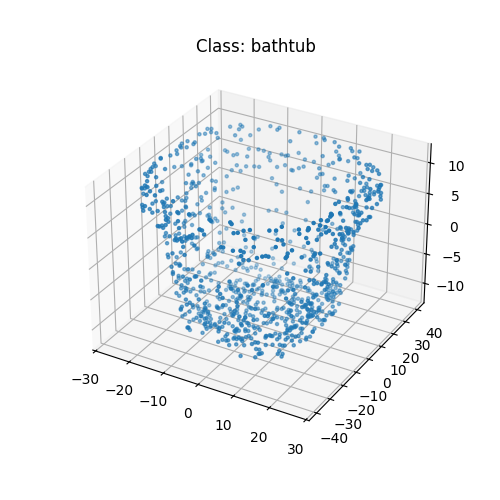

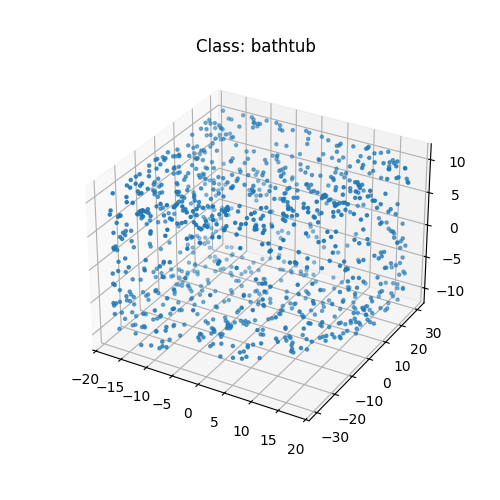

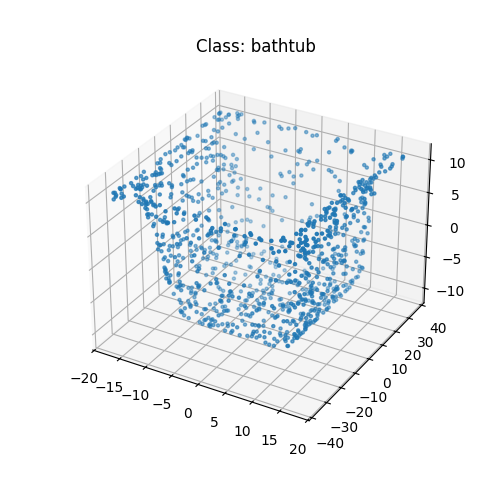

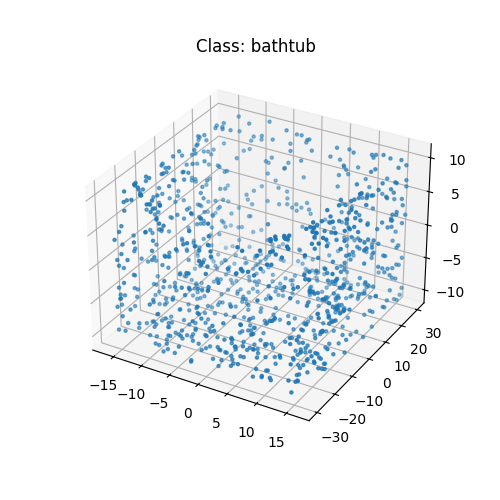

In [21]:
from IPython.display import Image, display

for i in range(num_samples):
    label = classes[train_dataset[i].y.item()]
    path = f"{output_dir}/{i+1}_{label}.png"
    display(Image(filename=path))

In [22]:
from torch_geometric.nn import knn_graph

def point_cloud_to_graph(data, k=16):
    data.edge_index = knn_graph(data.pos, k=k, batch=None, loop=False)
    return data

train_dataset = [point_cloud_to_graph(d) for d in train_dataset]
test_dataset = [point_cloud_to_graph(d) for d in test_dataset]

In [23]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [25]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_max_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=64, num_classes=10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [27]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.pos, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [28]:
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.pos, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

In [ ]:
for epoch in range(1, 21):
    loss = train()
    acc = test(test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

Epoch: 01, Loss: 7.1180, Test Accuracy: 0.1421
Epoch: 02, Loss: 2.9453, Test Accuracy: 0.5286
Epoch: 03, Loss: 3.2413, Test Accuracy: 0.5242
Epoch: 04, Loss: 2.2332, Test Accuracy: 0.6498
Epoch: 05, Loss: 1.6678, Test Accuracy: 0.5980
Epoch: 06, Loss: 1.8178, Test Accuracy: 0.6013
Epoch: 07, Loss: 3.1439, Test Accuracy: 0.6355
Epoch: 08, Loss: 2.2917, Test Accuracy: 0.6861
Epoch: 09, Loss: 0.9673, Test Accuracy: 0.6597
Epoch: 10, Loss: 1.2812, Test Accuracy: 0.7379
Epoch: 11, Loss: 0.7727, Test Accuracy: 0.7577
Epoch: 12, Loss: 0.7279, Test Accuracy: 0.7434
Epoch: 13, Loss: 0.6802, Test Accuracy: 0.7852
Epoch: 14, Loss: 1.6133, Test Accuracy: 0.6487
Epoch: 15, Loss: 6.2362, Test Accuracy: 0.6619
Epoch: 16, Loss: 1.3255, Test Accuracy: 0.7841
Epoch: 17, Loss: 0.9253, Test Accuracy: 0.7335
Epoch: 18, Loss: 0.6580, Test Accuracy: 0.7588
Epoch: 19, Loss: 0.6041, Test Accuracy: 0.8007
Epoch: 20, Loss: 0.5718, Test Accuracy: 0.7974


In [30]:
import time

k_values = [8, 16, 32]
results = []
epochs = 15

for k in k_values:
    print(f"\nTraining with k = {k}")
    start_time = time.time()

    train_data_k = [point_cloud_to_graph(d.clone(), k=k) for d in train_dataset]
    test_data_k  = [point_cloud_to_graph(d.clone(), k=k) for d in test_dataset]

    train_loader = DataLoader(train_data_k, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_data_k, batch_size=16)

    model = GCN(hidden_channels=64, num_classes=len(classes)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.pos, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        acc = test(test_loader)
        print(f"[k={k}] Epoch {epoch:02d} | Loss: {avg_loss:.4f} | Test Acc: {acc:.4f}")

    duration = time.time() - start_time
    results.append((k, acc, avg_loss, duration))


Training with k = 8
[k=8] Epoch 01 | Loss: 4.5320 | Test Acc: 0.4758
[k=8] Epoch 02 | Loss: 2.5046 | Test Acc: 0.5275
[k=8] Epoch 03 | Loss: 1.2966 | Test Acc: 0.3040
[k=8] Epoch 04 | Loss: 3.8063 | Test Acc: 0.4504
[k=8] Epoch 05 | Loss: 1.7859 | Test Acc: 0.5914
[k=8] Epoch 06 | Loss: 1.2081 | Test Acc: 0.6839
[k=8] Epoch 07 | Loss: 0.8339 | Test Acc: 0.6872
[k=8] Epoch 08 | Loss: 0.7589 | Test Acc: 0.7500
[k=8] Epoch 09 | Loss: 0.7098 | Test Acc: 0.7434
[k=8] Epoch 10 | Loss: 0.8460 | Test Acc: 0.7522
[k=8] Epoch 11 | Loss: 0.6514 | Test Acc: 0.7478
[k=8] Epoch 12 | Loss: 0.6016 | Test Acc: 0.8095
[k=8] Epoch 13 | Loss: 0.5782 | Test Acc: 0.7346
[k=8] Epoch 14 | Loss: 0.5214 | Test Acc: 0.7797
[k=8] Epoch 15 | Loss: 0.5100 | Test Acc: 0.7885

Training with k = 16
[k=16] Epoch 01 | Loss: 5.3222 | Test Acc: 0.4515
[k=16] Epoch 02 | Loss: 3.0991 | Test Acc: 0.4064
[k=16] Epoch 03 | Loss: 6.1419 | Test Acc: 0.4372
[k=16] Epoch 04 | Loss: 7.1276 | Test Acc: 0.4769
[k=16] Epoch 05 | Loss